In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = torch.sigmoid(self.fc_probs(x))
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        bern_dist = torch.distributions.Bernoulli(probs_x)
        x_recon = bern_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [5]:
LATENT_DIM = 16

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:08<02:37,  8.31s/it]

Epoch 1, Mean Training ELBO 198.6266259765625, Mean Validation ELBO 165.37245810546875


 10%|█         | 2/20 [00:14<02:02,  6.80s/it]

Epoch 2, Mean Training ELBO 140.39965716796874, Mean Validation ELBO 129.53071475830077


 15%|█▌        | 3/20 [00:19<01:47,  6.32s/it]

Epoch 3, Mean Training ELBO 120.7377879296875, Mean Validation ELBO 116.78336978759765


 20%|██        | 4/20 [00:25<01:37,  6.09s/it]

Epoch 4, Mean Training ELBO 113.1488461328125, Mean Validation ELBO 112.28716513671876


 25%|██▌       | 5/20 [00:31<01:29,  5.98s/it]

Epoch 5, Mean Training ELBO 109.6887723828125, Mean Validation ELBO 108.90090257568359


 30%|███       | 6/20 [00:37<01:22,  5.91s/it]

Epoch 6, Mean Training ELBO 107.57614876953124, Mean Validation ELBO 108.15873513183594


 35%|███▌      | 7/20 [00:42<01:16,  5.88s/it]

Epoch 7, Mean Training ELBO 105.6960549609375, Mean Validation ELBO 106.92206044921875


 40%|████      | 8/20 [00:48<01:10,  5.85s/it]

Epoch 8, Mean Training ELBO 104.586696015625, Mean Validation ELBO 105.10382474365234


 45%|████▌     | 9/20 [00:54<01:04,  5.83s/it]

Epoch 9, Mean Training ELBO 103.7232375390625, Mean Validation ELBO 104.23740705566406


 50%|█████     | 10/20 [01:00<00:58,  5.84s/it]

Epoch 10, Mean Training ELBO 102.8165575, Mean Validation ELBO 104.73917351074219


 55%|█████▌    | 11/20 [01:06<00:52,  5.84s/it]

Epoch 11, Mean Training ELBO 102.25574287109374, Mean Validation ELBO 103.23821042480469


 60%|██████    | 12/20 [01:12<00:46,  5.86s/it]

Epoch 12, Mean Training ELBO 101.65408029296874, Mean Validation ELBO 103.096440234375


 65%|██████▌   | 13/20 [01:17<00:41,  5.86s/it]

Epoch 13, Mean Training ELBO 101.1327366796875, Mean Validation ELBO 103.16380568847656


 70%|███████   | 14/20 [01:23<00:35,  5.87s/it]

Epoch 14, Mean Training ELBO 101.048531328125, Mean Validation ELBO 102.33493908691406


 75%|███████▌  | 15/20 [01:29<00:29,  5.86s/it]

Epoch 15, Mean Training ELBO 100.285301953125, Mean Validation ELBO 102.02245173339844


 80%|████████  | 16/20 [01:35<00:23,  5.85s/it]

Epoch 16, Mean Training ELBO 99.993179765625, Mean Validation ELBO 101.97195893554688


 85%|████████▌ | 17/20 [01:41<00:17,  5.85s/it]

Epoch 17, Mean Training ELBO 99.80365685546874, Mean Validation ELBO 101.99327969970703


 90%|█████████ | 18/20 [01:47<00:11,  5.84s/it]

Epoch 18, Mean Training ELBO 99.47564935546875, Mean Validation ELBO 102.18959530029296


 95%|█████████▌| 19/20 [01:53<00:05,  5.84s/it]

Epoch 19, Mean Training ELBO 99.35171041015624, Mean Validation ELBO 102.65871431884766


100%|██████████| 20/20 [01:58<00:00,  5.94s/it]

Epoch 20, Mean Training ELBO 99.03123578125, Mean Validation ELBO 101.5858837890625


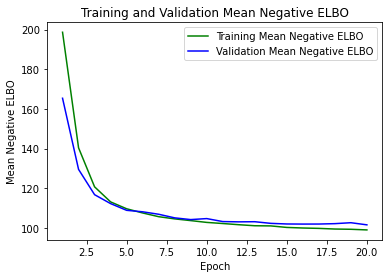

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20)

In [7]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        # x_recon = vae.reconstruct(probs_x)
        x_recon = probs_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

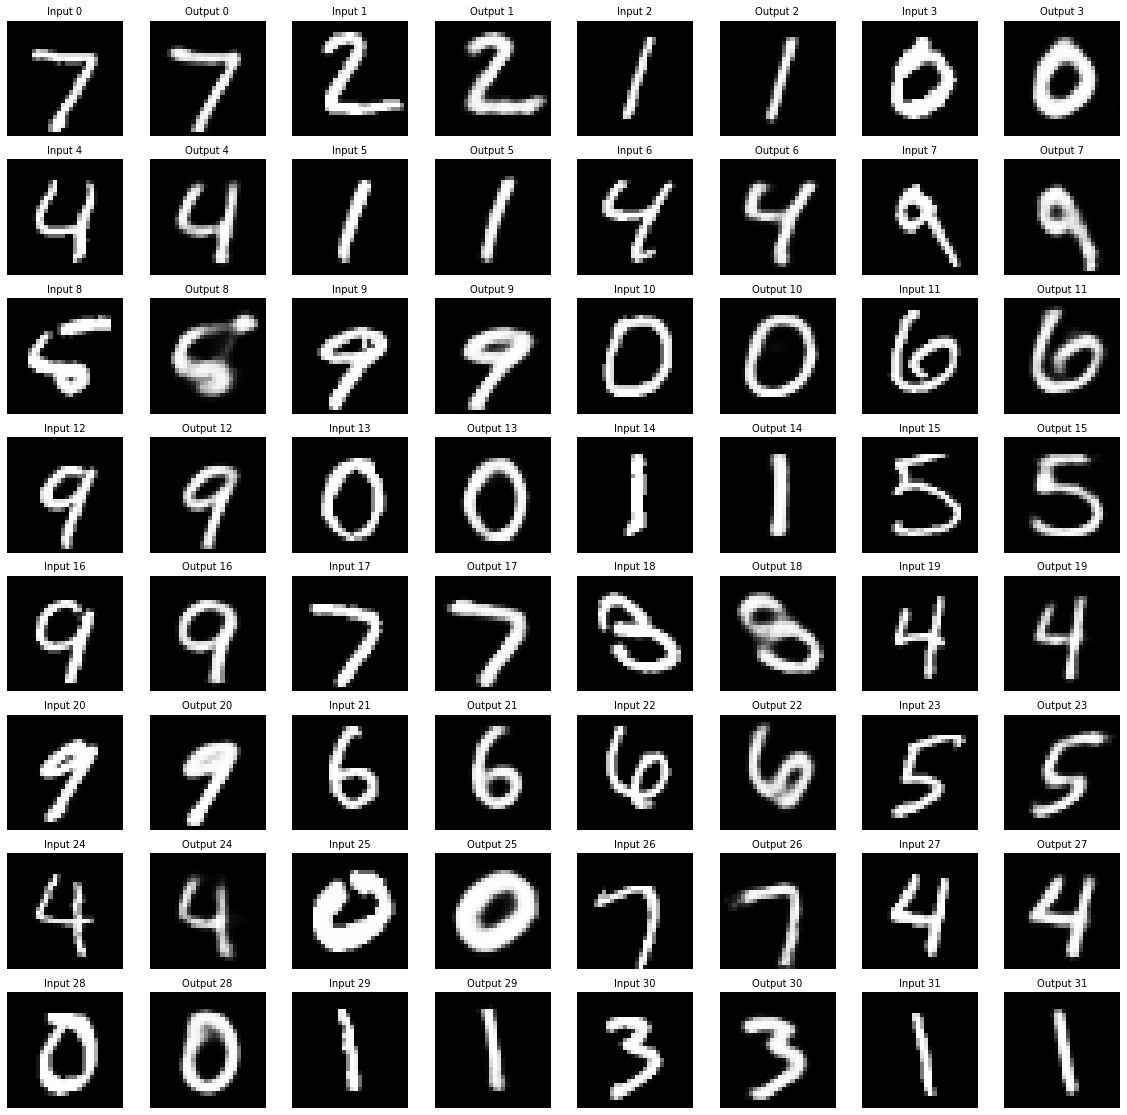

In [8]:
def show_images(x, x_recon):
    x = x.view(x.shape[0], 28, 28)
    x_recon = x_recon.view(x_recon.shape[0], 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

In [9]:
class Gaussian:
    def __init__(self, latent_dim):
        self.mu = torch.randn(latent_dim).to(DEVICE).detach().requires_grad_(True)
        self.log_var = torch.randn(latent_dim).to(DEVICE).detach().requires_grad_(True)

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z.unsqueeze(0)

In [10]:
gaussian = Gaussian(latent_dim=LATENT_DIM)
print(gaussian)
for param in decoder.parameters():
    param.requires_grad = False

In [11]:
# optimizer_gaussian = torch.optim.SGD([gaussian.mu, gaussian.log_var], lr=1e-3)

def train_gaussian(img_idx, model, optimizer, num_epochs, patience=100):
    train_elbos = []
    best_train_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    x = test_x[img_idx]
    x = x.to(DEVICE)
    for epoch in tqdm(range(num_epochs)):
        x_left = x[:, :, :int(IMG_W / 2)]
        x_left = torch.flatten(x_left, start_dim=1)
        optimizer.zero_grad()
        z = model.reparameterization(model.mu, model.log_var)
        probs_x = decoder(z)
        probs_x_squared = probs_x.view(probs_x.shape[0], IMG_H, IMG_W)
        probs_x_left = torch.flatten(probs_x_squared[:, :, :int(IMG_W / 2)], start_dim=1)
        log_p = -F.binary_cross_entropy(probs_x_left, x_left, reduction='sum')
        kl = -0.5 * torch.sum(1 + model.log_var - model.mu.pow(2) - model.log_var.exp())
        negative_elbo = -log_p + kl
        negative_elbo.backward()
        optimizer.step()
        train_elbo = negative_elbo.item()
        # if (epoch + 1) % 100 == 0:
        #     print('Epoch {}, Training ELBO {}'.format(epoch + 1, train_elbo))
        train_elbos.append(train_elbo)
        if train_elbo < best_train_elbo:
            best_train_elbo = train_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Negative ELBO')
    plt.title('Training Negative ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('Negative ELBO')
    plt.legend()
    plt.show()
# train_gaussian(img_idx=gaussian_img_idx, num_epochs=500, patience=100)

 45%|████▌     | 226/500 [00:00<00:00, 294.97it/s]


Early Stopped!


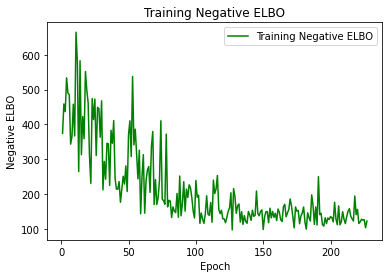

100%|██████████| 500/500 [00:01<00:00, 290.97it/s]


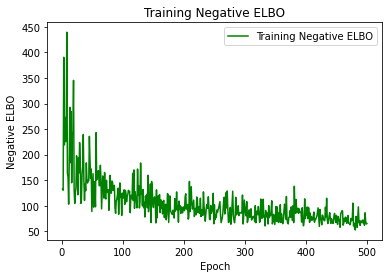

 26%|██▌       | 130/500 [00:00<00:01, 293.41it/s]


Early Stopped!


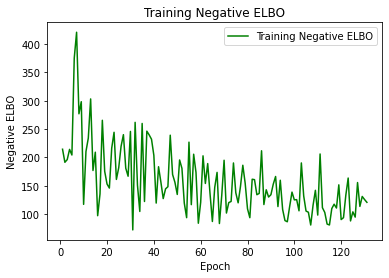

100%|██████████| 500/500 [00:01<00:00, 293.02it/s]


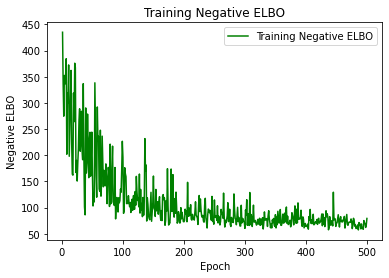

100%|██████████| 500/500 [00:01<00:00, 300.23it/s]


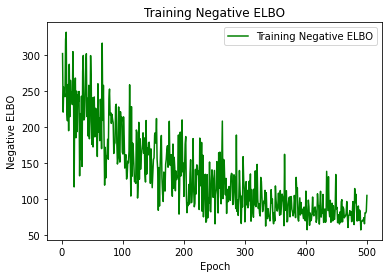

 46%|████▌     | 231/500 [00:00<00:00, 299.54it/s]


Early Stopped!


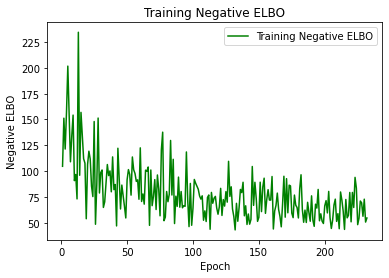

 62%|██████▏   | 310/500 [00:01<00:00, 299.45it/s]


Early Stopped!


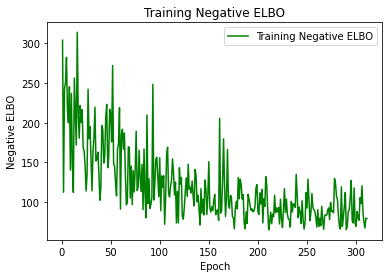

 51%|█████     | 254/500 [00:00<00:00, 298.05it/s]


Early Stopped!


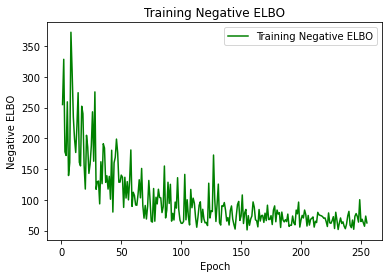

 43%|████▎     | 216/500 [00:00<00:00, 293.01it/s]


Early Stopped!


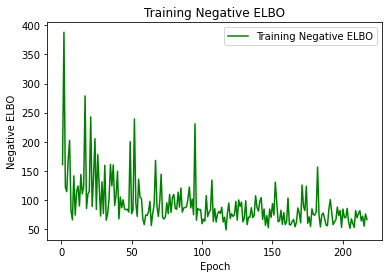

 81%|████████  | 403/500 [00:01<00:00, 293.24it/s]


Early Stopped!


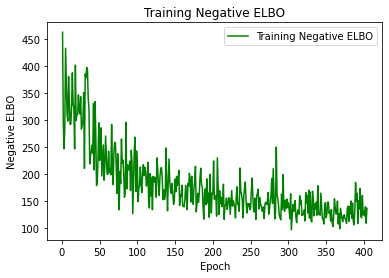

In [12]:
test_img_idxes = torch.randint(test_x.shape[0], size=(10,))
def test_image_completion(img_idxes):
    xs = test_x[img_idxes].to(DEVICE)
    x_right_recons = []
    for idx in img_idxes:
        model = Gaussian(latent_dim=LATENT_DIM)
        optimizer_model = torch.optim.SGD([model.mu, model.log_var], lr=1e-3)
        train_gaussian(img_idx=idx, model=model, optimizer=optimizer_model, num_epochs=500, patience=100)
        with torch.no_grad():
            z = model.reparameterization(model.mu, model.log_var)
            probs_x = decoder(z)
            probs_x = probs_x.view(probs_x.shape[0], IMG_H, IMG_W)
            x_right_recon = probs_x[:, :, int(IMG_W / 2):]
            x_right_recons.append(x_right_recon)
    x_right_recons = torch.cat(x_right_recons, dim=0)
    return xs, x_right_recons
test_batch_ic, test_batch_ic_right_recon = test_image_completion(test_img_idxes)

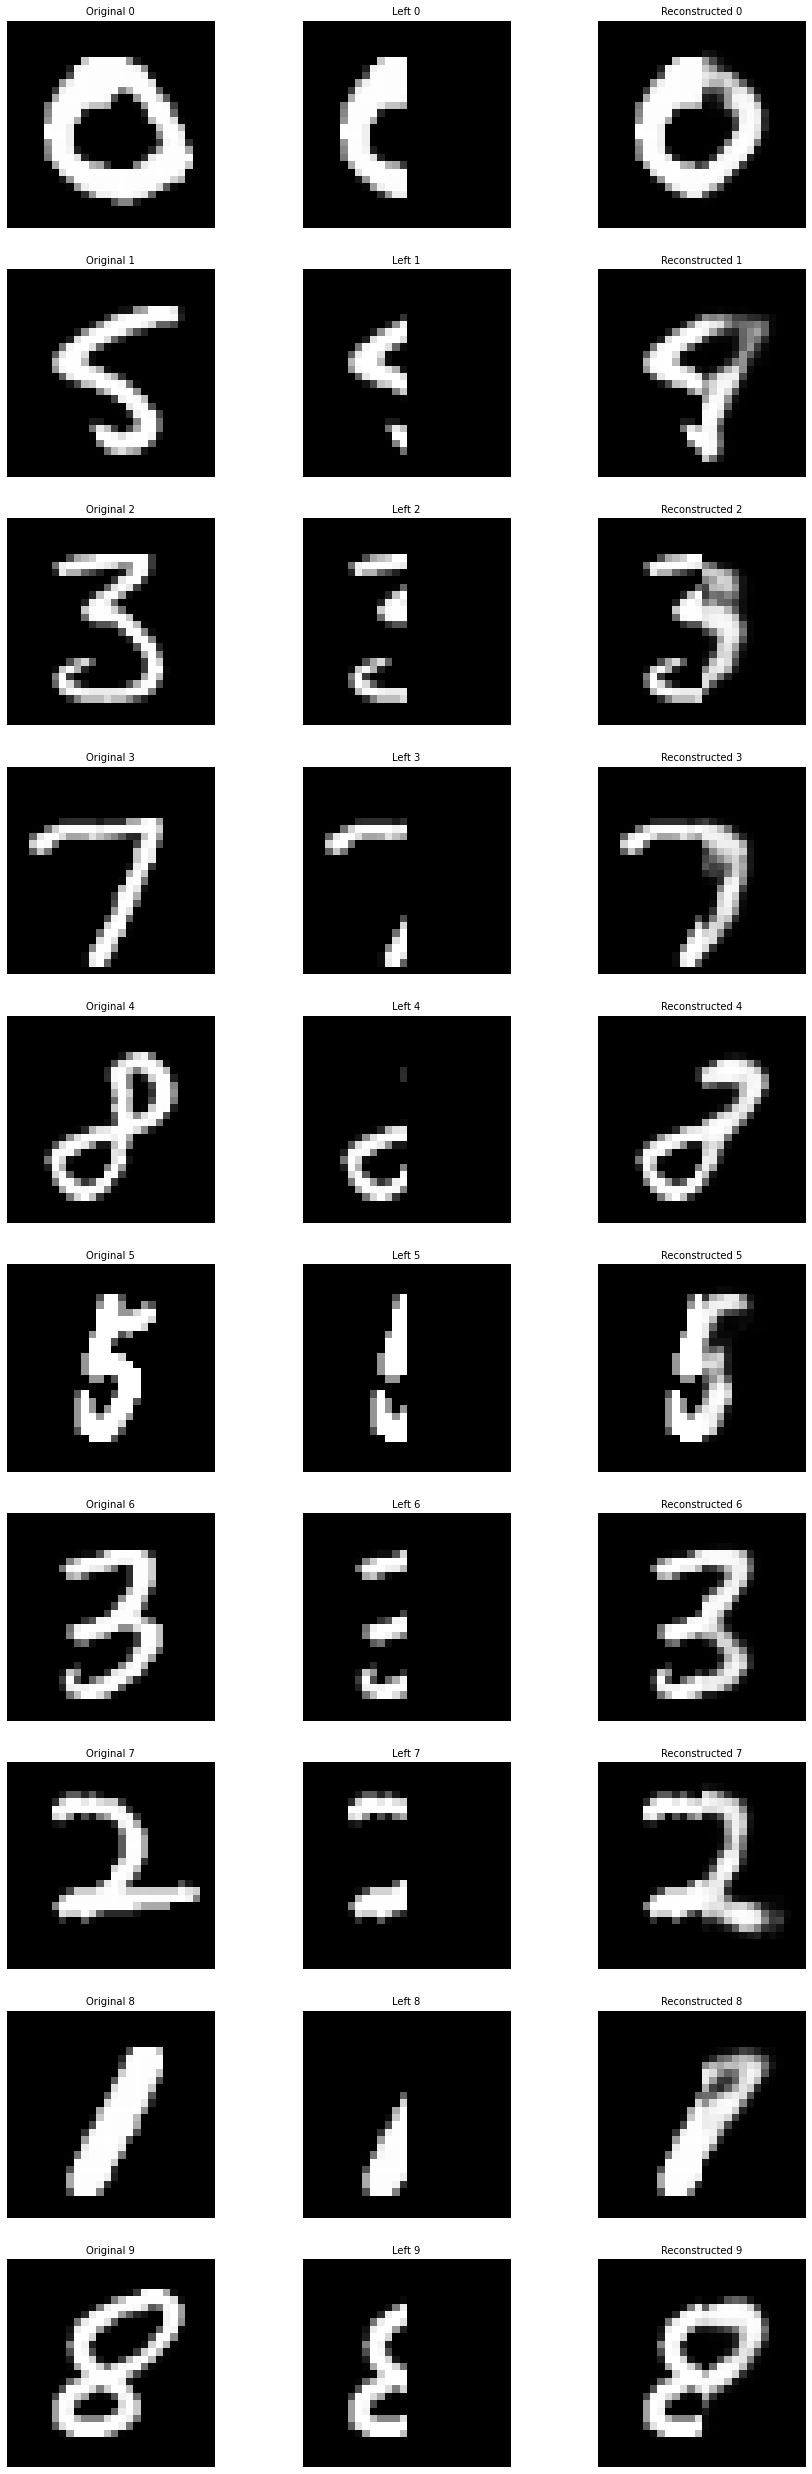

In [13]:
def show_image_completion(x, x_right_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], IMG_H, IMG_W)
    x_left = x[:, :, :int(IMG_W / 2)]
    x_right_covered = torch.zeros_like(x_left)
    x_covered = torch.cat((x_left, x_right_covered), dim=-1)
    x_right_recon = x_right_recon.view(x_right_recon.shape[0], IMG_H, int(IMG_W / 2))
    x_recon = torch.cat((x_left, x_right_recon), dim=-1)
    fig, ax = plt.subplots(10, 3, figsize=(15, 45))
    for i in range(10):
        ax[i][0].imshow(x[i].cpu().numpy(), cmap="Greys_r")
        ax[i][1].imshow(x_covered[i].cpu().numpy(), cmap="Greys_r")
        ax[i][2].imshow(x_recon[i].cpu().numpy(), cmap="Greys_r")
        ax[i][0].set_title(f"Original {i}", fontsize=10)
        ax[i][1].set_title(f"Left {i}", fontsize=10)
        ax[i][2].set_title(f"Reconstructed {i}", fontsize=10)
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
    plt.savefig('4b.png')
show_image_completion(test_batch_ic, test_batch_ic_right_recon)